# Import

In [10]:
import sys
!{sys.executable} -m pip install nltk

Defaulting to user installation because normal site-packages is not writeable
  Using cached nltk-3.9.2-py3-none-any.whl.metadata (3.2 kB)
Using cached nltk-3.9.2-py3-none-any.whl (1.5 MB)


In [4]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("waalbannyantudre/hate-speech-detection-curated-dataset")

print("Path to dataset files:", path)

/home/janhaf2n/.local/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: /home/janhaf2n/.cache/kagglehub/datasets/waalbannyantudre/hate-speech-detection-curated-dataset/versions/1


In [5]:
import pandas as pd
import os

for file in os.listdir(path):
    if file.endswith(".csv"):
        dataset_path = os.path.join(path, file)
        break

# Load the dataset
df = pd.read_csv(dataset_path)

# Show the first few rows
print("Dataset shape:", df.shape)
print("Head: ")
print(df.head())

Dataset shape: (440906, 3)
Head: 
                                             Content Label  \
0  denial of normal the con be asked to comment o...     1   
1  just by being able to tweet this insufferable ...     1   
2  that is retarded you too cute to be single tha...     1   
3  thought of a real badass mongol style declarat...     1   
4                                afro american basho     1   

                                         Content_int  
0  [146715, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,...  
1  [146715, 14, 15, 16, 17, 7, 18, 19, 20, 21, 22...  
2  [146715, 28, 29, 30, 26, 31, 32, 7, 5, 33, 28,...  
3  [146715, 35, 1, 24, 36, 37, 38, 39, 40, 1, 41,...  
4                       [146715, 46, 47, 48, 146714]  


# Clean and Preprocess Text

In [6]:
import numpy as np

y = pd.factorize(df["Label"])[0].astype(float)
print(y.shape)

# Print all unique values in y
print("Unique values in y:", np.unique(y))

# Print number of entries with each unique value
print("Counts of each unique value in y:", np.bincount(y.astype(int)))

# Print all entries from df["content"] where y = 2
print("Entries where y=2:")
print(df["Content"][y == 2])

(440906,)
Unique values in y: [0. 1. 2.]
Counts of each unique value in y: [ 79305 361594      7]
Entries where y=2:
190108    content
418486    content
422333    content
424241    content
426162    content
435474    content
437104    content
Name: Content, dtype: object


In [7]:
# Remove all entries where y = 2, as that isn't a valid label
df = df[y != 2]
print("Dataset shape:", df.shape)
print("Head: ")
print(df.head())

Dataset shape: (440899, 3)
Head: 
                                             Content Label  \
0  denial of normal the con be asked to comment o...     1   
1  just by being able to tweet this insufferable ...     1   
2  that is retarded you too cute to be single tha...     1   
3  thought of a real badass mongol style declarat...     1   
4                                afro american basho     1   

                                         Content_int  
0  [146715, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,...  
1  [146715, 14, 15, 16, 17, 7, 18, 19, 20, 21, 22...  
2  [146715, 28, 29, 30, 26, 31, 32, 7, 5, 33, 28,...  
3  [146715, 35, 1, 24, 36, 37, 38, 39, 40, 1, 41,...  
4                       [146715, 46, 47, 48, 146714]  


In [11]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import re

nltk.download("stopwords")

stemmer = PorterStemmer()
stop_words = set(stopwords.words("english"))

print("Cleaning text")
def clean_text(text):
    # Ensure it's a string
    text = str(text).lower()

    # Remove URLs
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)

    # Remove punctuation, numbers, special chars
    text = re.sub(r"[^a-z\s]", '', text)

    # Tokenize
    tokens = text.split()

    # Remove empty or stop words
    cleaned_tokens = []
    for w in tokens:
        if w and w not in stop_words:
            try:
                stemmed = stemmer.stem(w)
                cleaned_tokens.append(stemmed)
            except RecursionError:
                # If a weird token triggers recursion, skip it
                continue

    return " ".join(cleaned_tokens)

df["cleaned_content"] = df["Content"].apply(clean_text)
print("Text cleaning completed")
print("Shape: ", df.shape)
print("Head: ")
print(df.head())

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/janhaf2n/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Cleaning text
Text cleaning completed
Shape:  (440899, 4)
Head: 
                                             Content Label  \
0  denial of normal the con be asked to comment o...     1   
1  just by being able to tweet this insufferable ...     1   
2  that is retarded you too cute to be single tha...     1   
3  thought of a real badass mongol style declarat...     1   
4                                afro american basho     1   

                                         Content_int  \
0  [146715, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,...   
1  [146715, 14, 15, 16, 17, 7, 18, 19, 20, 21, 22...   
2  [146715, 28, 29, 30, 26, 31, 32, 7, 5, 33, 28,...   
3  [146715, 35, 1, 24, 36, 37, 38, 39, 40, 1, 41,...   
4                       [146715, 46, 47, 48, 146714]   

                                     cleaned_content  
0  denial normal con ask comment tragedi emot retard  
1  abl tweet insuffer bullshit prove trump nazi v...  
2                             retard cute singl life  
3  th

# TF-IDF

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer()
X_tfidf = tfidf_vectorizer.fit_transform(df["cleaned_content"])

# Only convert the first 5 rows to dense for display
sample_df = pd.DataFrame(
    X_tfidf[:5].toarray(),
    columns=tfidf_vectorizer.get_feature_names_out()
)

print("TF-IDF encoding completed")
print("Shape: ", X_tfidf.shape)
print("Sample head:")
print(sample_df.head())

TF-IDF encoding completed
Shape:  (440899, 101631)
Sample head:
    aa  aaa  aaaa  aaaaa  aaaaaa  aaaaaaa  aaaaaaaa  aaaaaaaaa  aaaaaaaaaa  \
0  0.0  0.0   0.0    0.0     0.0      0.0       0.0        0.0         0.0   
1  0.0  0.0   0.0    0.0     0.0      0.0       0.0        0.0         0.0   
2  0.0  0.0   0.0    0.0     0.0      0.0       0.0        0.0         0.0   
3  0.0  0.0   0.0    0.0     0.0      0.0       0.0        0.0         0.0   
4  0.0  0.0   0.0    0.0     0.0      0.0       0.0        0.0         0.0   

   aaaaaaaaaaa  ...  zzzzzzu  zzzzzzz  zzzzzzzz  zzzzzzzzzzzzzzz  \
0          0.0  ...      0.0      0.0       0.0              0.0   
1          0.0  ...      0.0      0.0       0.0              0.0   
2          0.0  ...      0.0      0.0       0.0              0.0   
3          0.0  ...      0.0      0.0       0.0              0.0   
4          0.0  ...      0.0      0.0       0.0              0.0   

   zzzzzzzzzzzzzzzzz  zzzzzzzzzzzzzzzzzzzzz  zzzzzzzzzzzzz

# Bag-of-Words

In [16]:
from sklearn.feature_extraction.text import CountVectorizer

bow_vectorizer = CountVectorizer()
X_bow = bow_vectorizer.fit_transform(df["cleaned_content"])

# Only convert the first 5 rows to dense for display
sample_bow_df = pd.DataFrame(
    X_bow[:5].toarray(),
    columns=bow_vectorizer.get_feature_names_out()
)

print("Bag-of-Words encoding completed")
print("Shape: ", X_bow.shape)
print("Sample head:")
print(sample_bow_df.head())

Bag-of-Words encoding completed
Shape:  (440899, 101631)
Sample head:
   aa  aaa  aaaa  aaaaa  aaaaaa  aaaaaaa  aaaaaaaa  aaaaaaaaa  aaaaaaaaaa  \
0   0    0     0      0       0        0         0          0           0   
1   0    0     0      0       0        0         0          0           0   
2   0    0     0      0       0        0         0          0           0   
3   0    0     0      0       0        0         0          0           0   
4   0    0     0      0       0        0         0          0           0   

   aaaaaaaaaaa  ...  zzzzzzu  zzzzzzz  zzzzzzzz  zzzzzzzzzzzzzzz  \
0            0  ...        0        0         0                0   
1            0  ...        0        0         0                0   
2            0  ...        0        0         0                0   
3            0  ...        0        0         0                0   
4            0  ...        0        0         0                0   

   zzzzzzzzzzzzzzzzz  zzzzzzzzzzzzzzzzzzzzz  zzzzzzzzzzzzz

# Correlation

In [ ]:
from scipy.stats import pearsonr
import pandas as pd

import numpy as np
import pandas as pd
from scipy import sparse

def correlations(X_sparse, y, feature_names, batch_size=1000):
    """
    Memory-safe sparse Pearson correlation for very large matrices.
    """
    if not sparse.isspmatrix_csr(X_sparse):
        X_sparse = X_sparse.tocsr()
    
    # Convert y to numeric if needed
    if not np.issubdtype(np.asarray(y).dtype, np.number):
        y = pd.factorize(y)[0]
    y = np.asarray(y, dtype=float).ravel()
    n = X_sparse.shape[0]

    y_mean = y.mean()
    y_std = y.std()
    y_centered = y - y_mean

    corrs = np.zeros(X_sparse.shape[1], dtype=np.float32)

    for start in range(0, X_sparse.shape[1], batch_size):
        end = min(start + batch_size, X_sparse.shape[1])
        X_batch = X_sparse[:, start:end]

        # Compute feature means and variances efficiently
        means = np.array(X_batch.mean(axis=0)).ravel()
        sumsq = np.array(X_batch.multiply(X_batch).mean(axis=0)).ravel()
        vars_ = sumsq - means**2
        stds = np.sqrt(np.maximum(vars_, 1e-12))

        # Compute covariances without centering the whole matrix
        cov = (X_batch.T.dot(y_centered) - n * means * y_mean) / (n - 1)

        # Correlation
        corrs[start:end] = cov / (stds * y_std)

    return pd.Series(corrs, index=feature_names).replace([np.inf, -np.inf], 0).fillna(0).sort_values(ascending=False)

y = pd.to_numeric(df["Label"], errors="coerce")

bow_feature_names = bow_vectorizer.get_feature_names_out() 
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()

corr_bow = correlations(X_bow, y, bow_feature_names).sort_values(ascending=False)
corr_tfidf = correlations(X_tfidf, y, tfidf_feature_names).sort_values(ascending=False)

print_top_n = 20
print(f"Top {print_top_n} most correlated (BoW):")
print(corr_bow.head(print_top_n))
print(f"{print_top_n} least correlated (BoW):")
print(corr_bow.tail(print_top_n))

print(f"Top {print_top_n} most correlated (TF-IDF):")
print(corr_tfidf.head(print_top_n))
print(f"{print_top_n} least correlated (TF-IDF):")
print(corr_tfidf.tail(print_top_n))

Top 20 most correlated (BoW):
fuck            0.066465
sexist          0.062706
faggot          0.058680
retard          0.057073
stupid          0.049305
shithol         0.047364
chong           0.045731
ching           0.045558
women           0.044854
je              0.043574
spic            0.040334
sto             0.040121
shut            0.039315
asshol          0.036624
za              0.036551
ti              0.035876
nonsexist       0.034891
koi             0.032253
bastard         0.032086
deportthemal    0.031994
dtype: float32
20 least correlated (BoW):
whatev      -0.155427
make        -0.156968
remov       -0.157502
time        -0.159483
think       -0.161016
like        -0.162052
sourc       -0.165689
see         -0.166678
wikipedia   -0.169929
use         -0.174575
also        -0.187205
one         -0.196700
talk        -0.197376
edit        -0.208203
would       -0.216938
pleas       -0.228304
thank       -0.229686
slut        -0.233378
page        -0.233741
articl    

# Dataset Analysis

Dataset Overview:
<class 'pandas.core.frame.DataFrame'>
Index: 440899 entries, 0 to 440905
Data columns (total 4 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   Content          440899 non-null  object
 1   Label            440899 non-null  object
 2   Content_int      440899 non-null  object
 3   cleaned_content  440899 non-null  object
dtypes: object(4)
memory usage: 16.8+ MB
None 

                                                  Content   Label  \
count                                              440899  440899   
unique                                             417560       2   
top     please do not address nonsense to wikipedia it...       0   
freq                                                    4  361594   

                                              Content_int cleaned_content  
count                                              440899          440899  
unique                                             4175

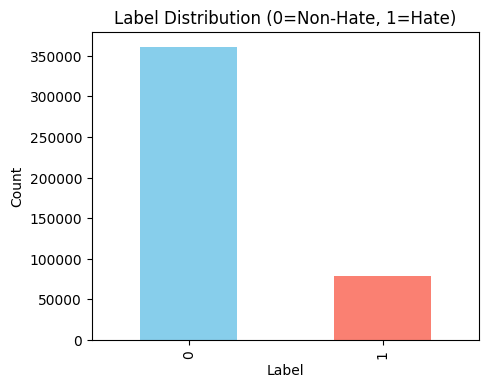

Word Count Statistics:
count    440899.000000
mean         21.145314
std          25.022984
min           0.000000
25%           6.000000
50%          12.000000
75%          25.000000
max         294.000000
Name: word_count, dtype: float64


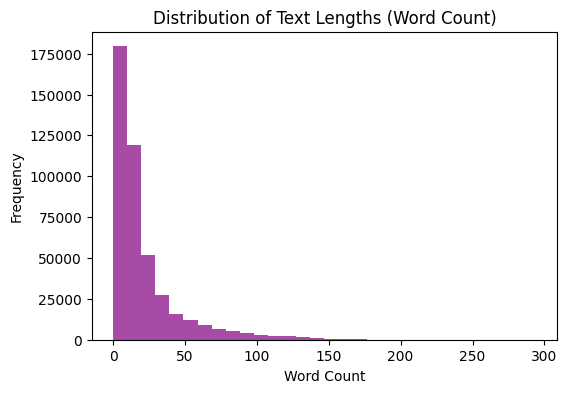

Top 50 Most Frequent Words:
[('articl', 110762), ('page', 85940), ('slut', 83368), ('edit', 60063), ('like', 59787), ('would', 57583), ('wikipedia', 57276), ('use', 54875), ('one', 51786), ('talk', 49304), ('pleas', 49264), ('whatev', 45229), ('delet', 44004), ('see', 43109), ('thank', 42176), ('think', 40695), ('peopl', 39898), ('get', 38355), ('know', 37513), ('go', 36553), ('make', 36167), ('sourc', 34481), ('time', 33507), ('say', 32299), ('also', 30544), ('want', 30404), ('need', 28906), ('fuck', 28382), ('look', 27477), ('good', 24805), ('name', 23925), ('remov', 23691), ('link', 23255), ('work', 23067), ('person', 22840), ('help', 22458), ('well', 22201), ('mean', 22192), ('even', 22156), ('user', 21585), ('block', 21566), ('discuss', 21547), ('could', 21240), ('list', 20768), ('point', 20424), ('inform', 20061), ('imag', 20001), ('tri', 19548), ('comment', 19545), ('new', 19438)]
Unique and Duplicate Text Entries:
Unique text entries: 417560
Duplicate entries: 23339


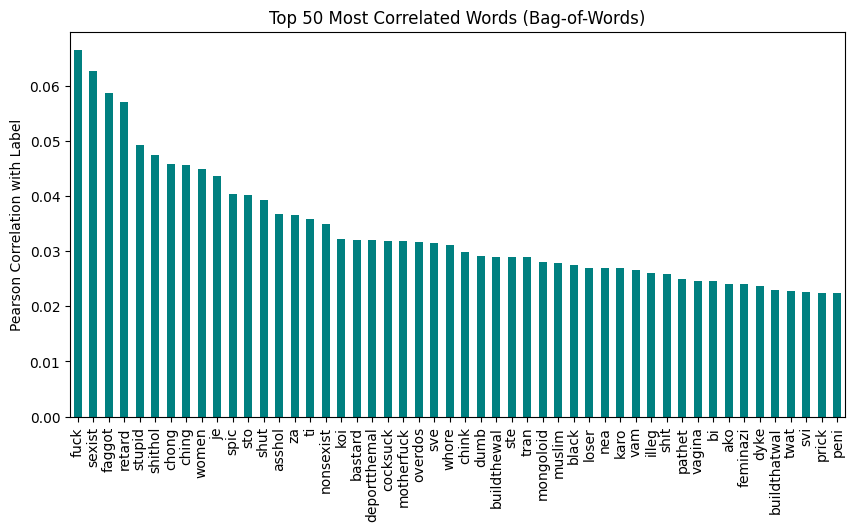

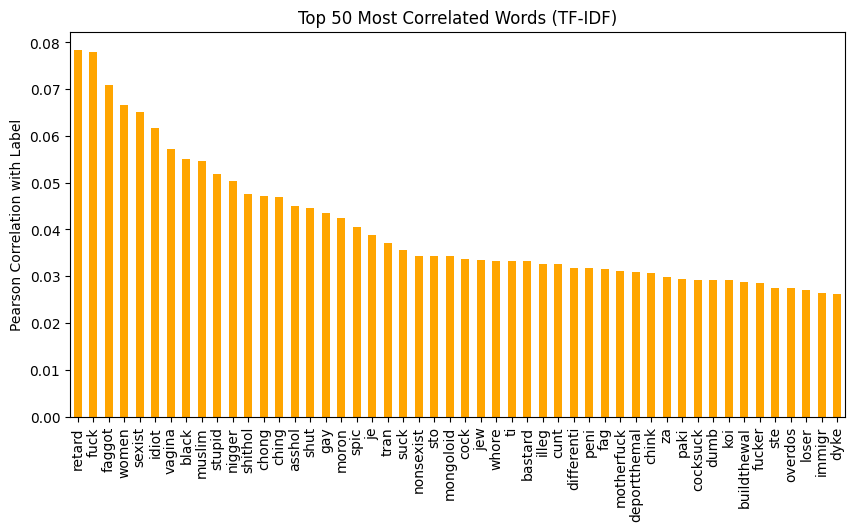

In [65]:
import matplotlib.pyplot as plt
from collections import Counter

print("Dataset Overview:")
print(df.info(), "\n")
print(df.describe(include='all'))
print("\nClass distribution:")
print(df['Label'].value_counts(normalize=True) * 100)

print("Missing Values:")
print(df.isnull().sum())

plt.figure(figsize=(5,4))
df['Label'].value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
plt.title("Label Distribution (0=Non-Hate, 1=Hate)")
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()

df['word_count'] = df['cleaned_content'].apply(lambda x: len(str(x).split()))
print("Word Count Statistics:")
print(df['word_count'].describe())

plt.figure(figsize=(6,4))
plt.hist(df['word_count'], bins=30, color='purple', alpha=0.7)
plt.title("Distribution of Text Lengths (Word Count)")
plt.xlabel("Word Count")
plt.ylabel("Frequency")
plt.show()

all_words = " ".join(df["cleaned_content"]).split()
freq = Counter(all_words)
print("Top 50 Most Frequent Words:")
print(freq.most_common(50))

print("Unique and Duplicate Text Entries:")
print("Unique text entries:", df['Content'].nunique())
print("Duplicate entries:", df.duplicated(subset='Content').sum())

# Plot top correlated features for BoW
plt.figure(figsize=(10,5))
corr_bow.head(50).plot(kind='bar', color='teal')
plt.title("Top 50 Most Correlated Words (Bag-of-Words)")
plt.ylabel("Pearson Correlation with Label")
plt.show()

# Plot top correlated features for TF-IDF
plt.figure(figsize=(10,5))
corr_tfidf.head(50).plot(kind='bar', color='orange')
plt.title("Top 50 Most Correlated Words (TF-IDF)")
plt.ylabel("Pearson Correlation with Label")
plt.show()

# Save

In [17]:
import scipy.sparse

# Save cleaned DataFrame
df_cleaned = df.copy()
df_cleaned["cleaned_content"] = df["cleaned_content"]

ROOT = "/home/janhaf2n/fundML_Project/"

output_cleaned_path = os.path.join(ROOT, "cleaned_hate_speech_dataset.csv")
df_cleaned.to_csv(output_cleaned_path, index=False)
print(f"Cleaned dataset saved to: {output_cleaned_path}")

# Save TF-IDF sparse matrix and feature names
output_tfidf_matrix = os.path.join(ROOT, "tfidf_matrix.npz")
output_tfidf_features = os.path.join(ROOT, "tfidf_features.txt")
scipy.sparse.save_npz(output_tfidf_matrix, X_tfidf)
with open(output_tfidf_features, "w", encoding="utf-8") as f:
    for feat in tfidf_vectorizer.get_feature_names_out():
        f.write(f"{feat}\n")
print(f"TF-IDF matrix saved to: {output_tfidf_matrix}")
print(f"TF-IDF feature names saved to: {output_tfidf_features}")

# Save BoW sparse matrix and feature names
output_bow_matrix = os.path.join(ROOT, "bow_matrix.npz")
output_bow_features = os.path.join(ROOT, "bow_features.txt")
scipy.sparse.save_npz(output_bow_matrix, X_bow)
with open(output_bow_features, "w", encoding="utf-8") as f:
    for feat in bow_vectorizer.get_feature_names_out():
        f.write(f"{feat}\n")
print(f"BoW matrix saved to: {output_bow_matrix}")
print(f"BoW feature names saved to: {output_bow_features}")

Cleaned dataset saved to: /home/janhaf2n/fundML_Project/cleaned_hate_speech_dataset.csv
TF-IDF matrix saved to: /home/janhaf2n/fundML_Project/tfidf_matrix.npz
TF-IDF feature names saved to: /home/janhaf2n/fundML_Project/tfidf_features.txt
BoW matrix saved to: /home/janhaf2n/fundML_Project/bow_matrix.npz
BoW feature names saved to: /home/janhaf2n/fundML_Project/bow_features.txt
